In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
from scipy.optimize import fsolve 
import sys
import time
from scipy import optimize
from numpy import savetxt

In [2]:
Dimensions=400
Dimensions_1 = 200
Dimensions_2= 200
PI = np.pi
K = 0.56085639
DEGREE = 2
global Dimensions, PI, K,DEGREE

In [3]:
C_RANGES= np.reshape(np.linspace(1e-12, 0.999999, Dimensions), (-1,1))
#a1=np.linspace(1e-12,0.5-(0.999-0.5)/Dimensions_2, Dimensions_1) 
#a2=np.linspace(0.5,0.999, Dimensions_2) 
#C_RANGES= np.reshape(np.concatenate((a1, a2), axis=0), (-1,1))
THETA_RANGES = np.linspace(0, 2*PI, Dimensions)

In [4]:
def pertubation(theta):
    return (np.cos(3*theta)+np.cos(8*theta)+np.sin(13*theta))

In [5]:
def dev_pertubation(theta):
    return 13*np.cos(13*theta)-8*np.sin(8*theta)-3*np.sin(3*theta)

In [6]:
def radius(theta, c, m):
    pertu = pertubation(theta)
    scalling = 1/(np.power((1+c), m))
    r = scalling*((1-c)**0.5*K)+(np.power(1-c, 4)*0.05*pertu)###use 0.561 to sure the surface = 1
    return r

In [7]:
def Dev_r_theta(theta, c, m):
    dev_per = dev_pertubation(theta)
    d_r = 0.05*np.power((1-c), 4)*dev_per
    return d_r

In [8]:
def Dev_r_c(theta, c, m):
    pertu = pertubation(theta)*0.05
    A = 1/(np.power((1+c), m))
    B = (1-c)**0.5*K
    dA = -m*np.power(1+c, -m-1)
    dB = -0.5*K*(1-c)**(-0.5)
    dC = pertu*(4)*((1-c)**((4)-1))####require C != 1, when C == 1, there will be a signarity.
    d_r = A*dB+B*dA+dC
    return d_r

In [9]:
def Dev_h_c(c, n):
    d_h = n*np.power(c, n-1)####set c_max=1
    return d_h

In [10]:
def Height_volume(v, n, M, Radius, Theta_ranges, C_ranges):
    dimen_c = len(C_ranges)
    
    d_theta = Theta_ranges[1]-Theta_ranges[0]#(Theta_ranges[-1]-Theta_ranges[0])/Dimensions
    C_RANGES_diff = np.diff(C_ranges, axis=0)
    C_RANGES_diff = np.reshape(np.append(C_RANGES_diff, C_RANGES_diff[-1,0] ), (-1,1))
    d_c = C_RANGES_diff
    d_base_area = 0.5*(Radius**2)*d_theta


    d_h = Dev_h_c(C_ranges, n)
    dv = (d_base_area*d_h)*d_c

    volume = np.sum(dv)

    H = v/volume
     
    d_r_theta = Dev_r_theta(Theta_ranges, C_ranges, M)
    d_r_c = Dev_r_c(Theta_ranges, C_ranges, M)
  
    d_h_c = H*d_h
    
    
    ds = np.sqrt(Radius**2+d_r_theta**2)*d_theta
    dl = np.sqrt(d_r_c**2+d_h_c**2)*d_c
    
    surface = ds*dl

    
    surface_size = np.sum(surface)
    
    return H, surface_size
    

In [11]:
def Main(v, n_ranges, m_ranges, Theta_ranges, C_ranges):
    n_length = len(n_ranges)
    m_length = len(m_ranges)
    surface_matrix = np.zeros((m_length, n_length))
    height_matrix = np.zeros((m_length, n_length))
    for i in range(m_length):
        Radius = radius(Theta_ranges, C_ranges, m_ranges[i])
        for j in range(n_length):
            height, surface = Height_volume(v, n_ranges[j], m_ranges[i], Radius, Theta_ranges, C_ranges)
            surface_matrix[i][j] = surface
            height_matrix[i][j] = height
    surface_min = surface_matrix.min()
    index = np.where(surface_matrix==np.min(surface_matrix))
    height_min = height_matrix[index][0]
    return surface_min, height_min, surface_matrix, m_ranges[index[0]], n_ranges[index[1]]

In [12]:
# def loop_volume(v):
#     m_l=[1, 0.5,0.1,0.05,0.01,0.005,0.001]
#     n_l=[0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
#     levels = len(m_l)
#     n_start = 0.5
#     n_stop = 3
#     m_start = -10
#     m_stop = 20
#     i = 0 
#     Start = True
#     while (i<levels):
#         dimen = 200
#         if (Start==True):
#             m_ranges = np.arange(m_start, m_stop, m_l[i])
#             n_ranges = np.arange(n_start,n_stop, n_l[i])
#             Start = False
#         else:
#             pass
# #         print(m_ranges)
# #         print(n_ranges)
#         s_g, h_g,energy_g= Main(v,n_ranges, m_ranges, THETA_RANGES, C_RANGES)
#         index = np.where(energy_g == np.min(energy_g))
#         m = index[0][0]
#         n = index[1][0]
# #         print('i', i)
# #         print('m', m)
# #         print('n', n)
#         m_lst_index = len(m_ranges)-1
#         n_lst_index = len(n_ranges)-1
#         if (m ==0)|(m==m_lst_index)|(n==0)|(n==n_lst_index):
#             m_ranges = np.arange(m_ranges[m]-m_l[i], m_ranges[m]+2*m_l[i], m_l[i])
#             n_ranges = np.arange(n_ranges[n]-n_l[i], n_ranges[n]+2*n_l[i], n_l[i])
#         else:
#             if (i+1) <levels:
#                 m_ranges = np.arange(m_ranges[m]-m_l[i], m_ranges[m]+m_l[i]+m_l[i+1], m_l[i+1])
#                 n_ranges = np.arange(n_ranges[n]-n_l[i], n_ranges[n]+n_l[i]+n_l[i+1], n_l[i+1])
#                 i = i+1
#             else:
#                 break
#     surface = s_g
#     height = h_g
#     Energy = energy_g
#     return surface, height, Energy,  m_ranges[m], n_ranges[n]

In [13]:
m_ranges = np.arange(-1, 1, 0.01)
n_ranges = np.arange(0.6,2, 0.01)
Volume = [0.1]#,0.5,1]#[0.06,0.10,0.14, 0.18,0.5, 1, 1.5]
Surface = []
Height = []
Energy = []
m_matrix = []
n_matrix = []
for v in Volume:
    s,h,e,m,n = Main(v, n_ranges, m_ranges, THETA_RANGES, C_RANGES)
    Surface.append(s)
    Height.append(h)
    Energy.append(e)
    m_matrix.append(m)
    n_matrix.append(n)

In [14]:
# m_ranges = np.linspace(-8, 10, 800)
# n_ranges = np.linspace(0.001, 4, 160)
# #########ACCORDING to the calculation from Square_with_gravity, m in the range of (0.975,1.952),n in the range of (1.189,1.561);
# Volume = [0.02,0.06,0.10,0.14, 0.18,0.5, 1, 1.5]
# Surface = []
# Height = []
# Energy = []
# m_matrix = []
# n_matrix = []
# for v in Volume:
#     s,h,e = Main(v, n_ranges, m_ranges, THETA_RANGES, C_RANGES)
#     Surface.append(s)
#     Height.append(h)
#     Energy.append(e)

In [15]:
#################THEO######################
Height

[0.20661794446760143]

In [16]:
##############THEO#################
Surface#####

[1.1791239606006596]

In [17]:
m_matrix

[array([-0.16])]

In [18]:
n_matrix

[array([1.27])]

In [19]:
surface_energy = Energy[0]

In [20]:
savetxt('flower01.csv', surface_energy, delimiter=',')

In [21]:
Volume_sim = [0.06,0.10,0.14, 0.18,0.5, 1, 1.5]
SS_sim = np.array([10395,11578,12986,14179,25421,41766,55506])*1e-4
HH_sim = (np.array([20.61,27.72,34.06,39.19,71.78,102.28,122.06])-5)*0.01

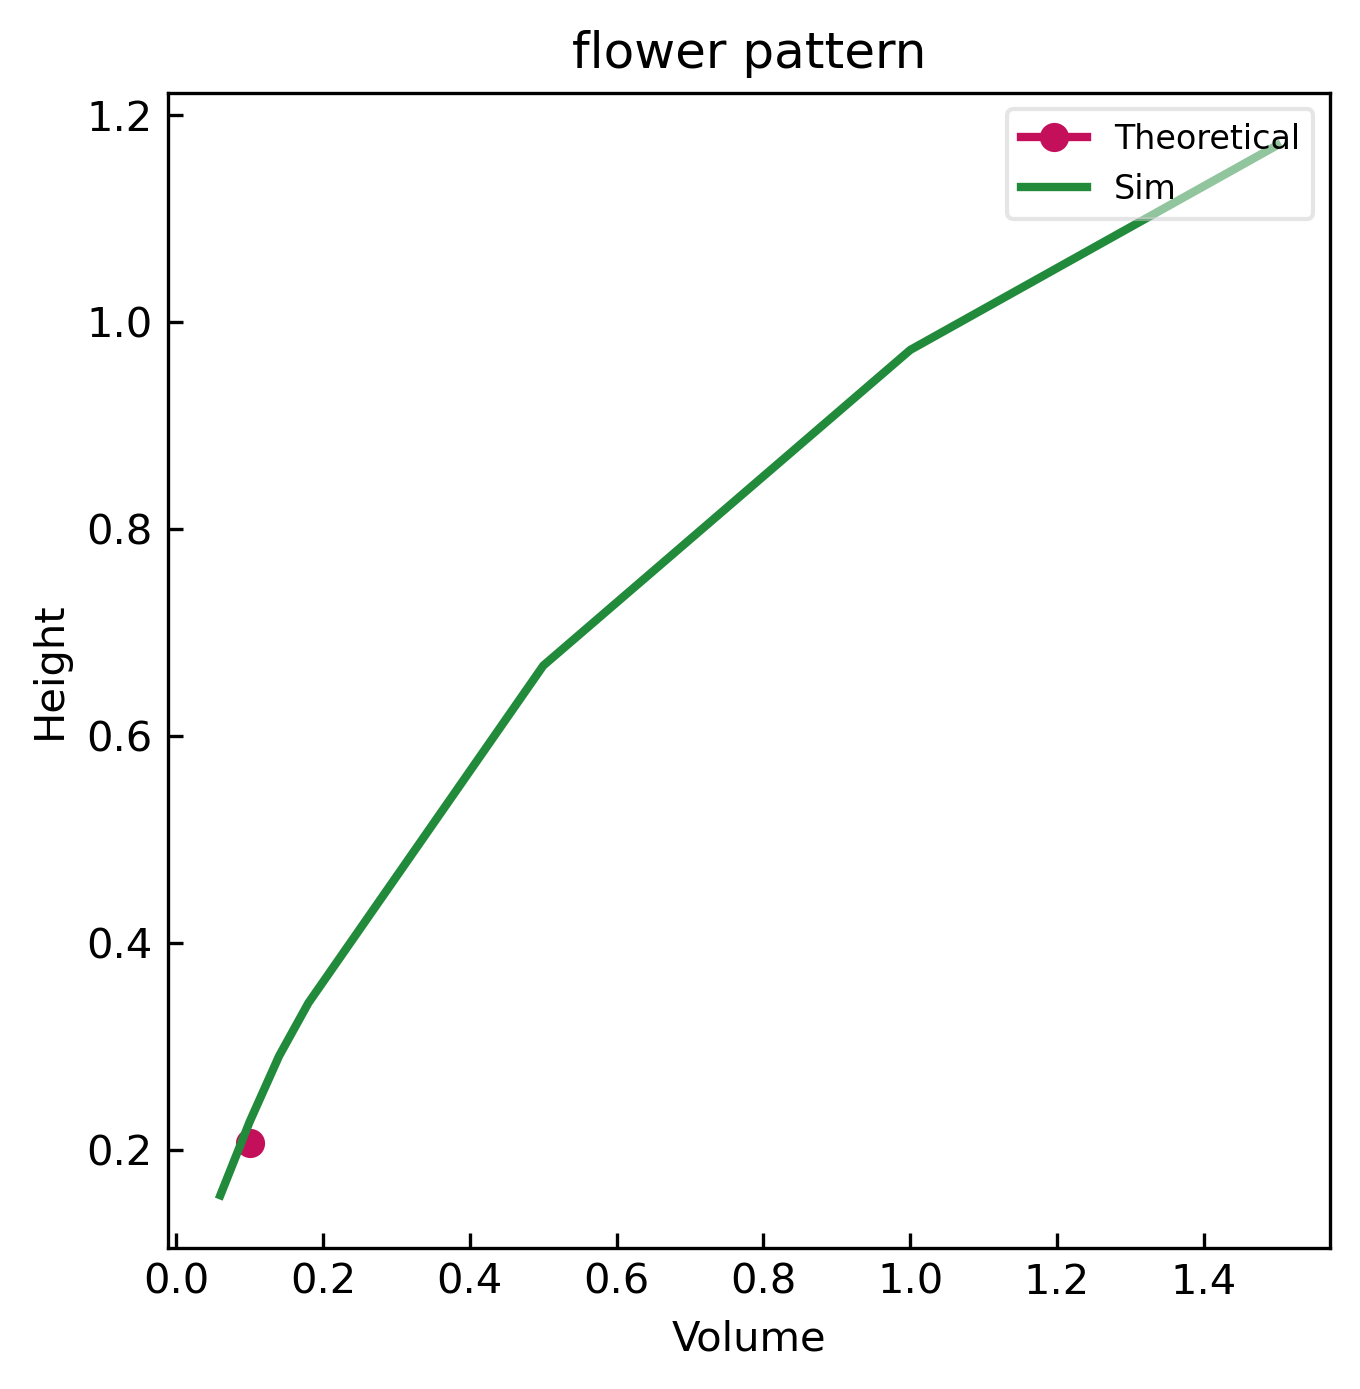

In [22]:
fig = plt.figure(figsize=(5,5), dpi=300)
ax_1=fig.add_subplot(1,1,1)




ax_1.plot(Volume,Height,color="#C40f5B",lw =2, marker = 'o', label = 'Theoretical')



ax_1.plot(Volume_sim,HH_sim,color="#228B3B",lw =2, marker = 'o',markersize=0.2, label = 'Sim')




ax_1.set_title('flower pattern')
ax_1.set_ylabel('Height')
ax_1.set_xlabel('Volume')


ax_1.legend(loc='upper right', fontsize=8, numpoints=1, framealpha=0.5)
ax_1.tick_params(axis="y", direction='in')
ax_1.tick_params(axis="x", direction='in')
# plt.savefig('flower_height.pdf', bbox_inches='tight')

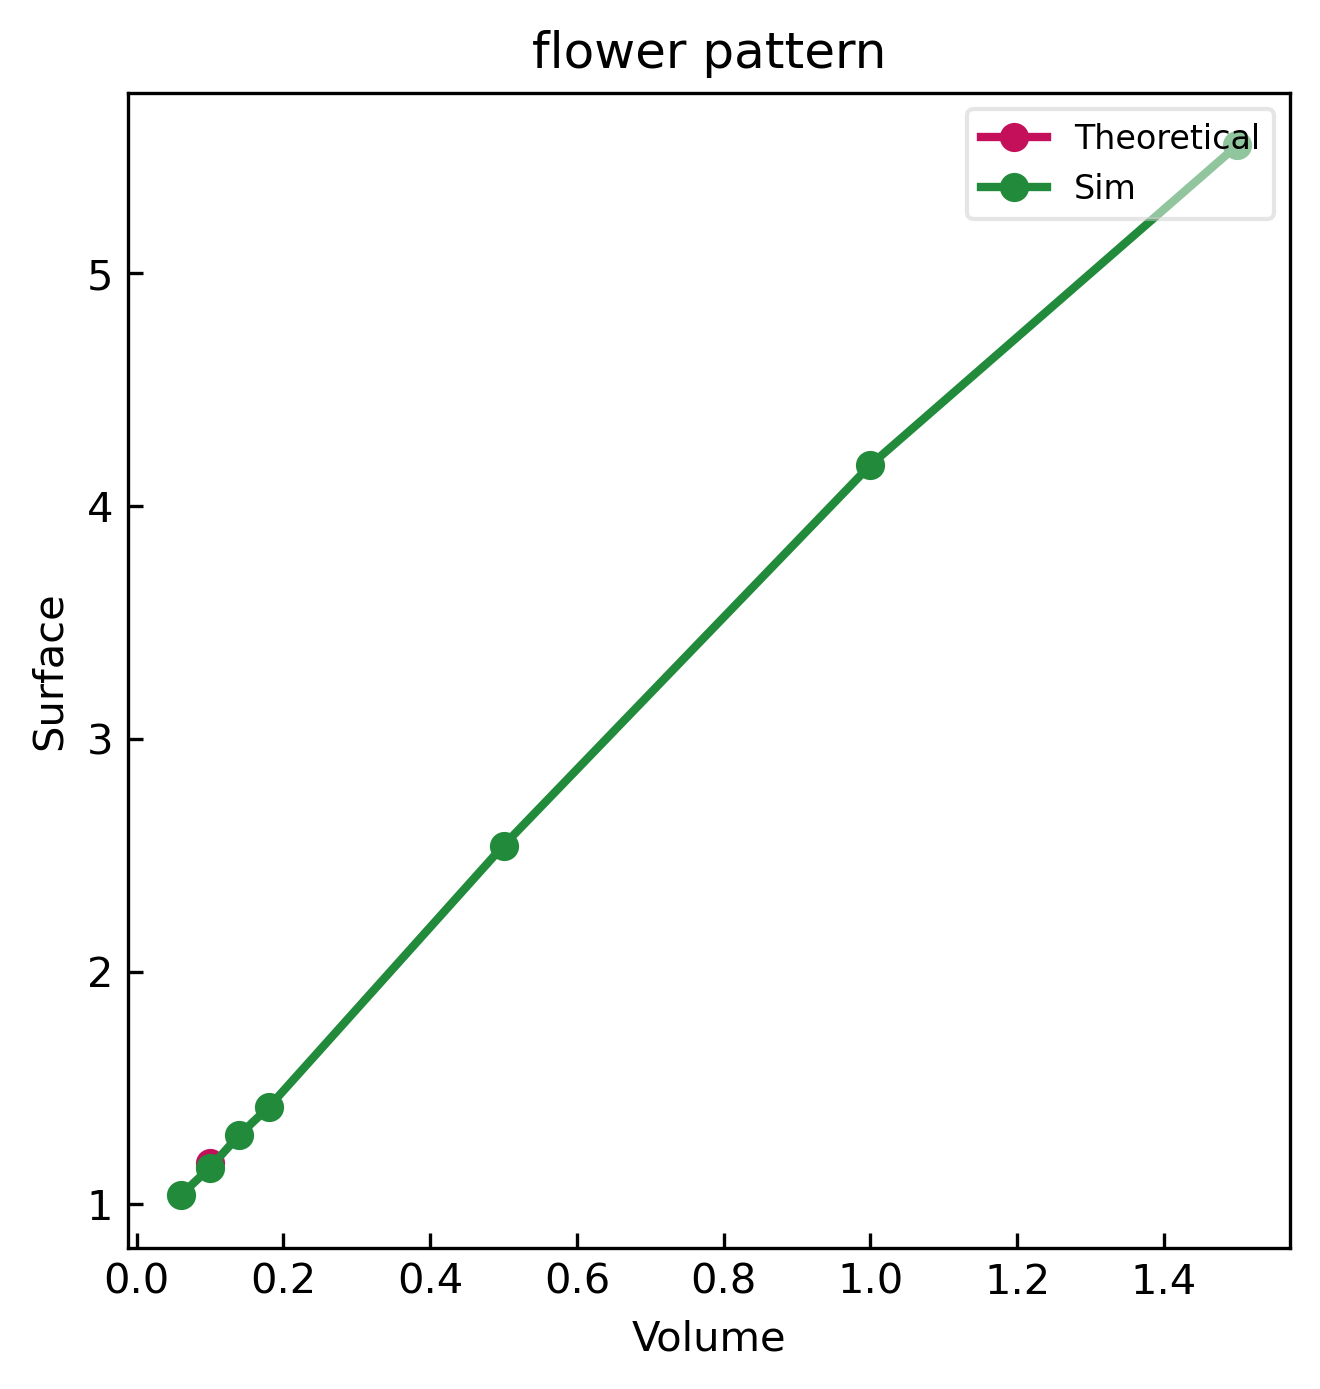

In [23]:
fig = plt.figure(figsize=(5,5), dpi=300)
ax_1=fig.add_subplot(1,1,1)




ax_1.plot(Volume,Surface,color="#C40f5B",lw =2, marker = 'o', label = 'Theoretical')



ax_1.plot(Volume_sim,SS_sim,color="#228B3B",lw =2, marker = 'o', label = 'Sim')





ax_1.set_title('flower pattern')
ax_1.set_ylabel('Surface')
ax_1.set_xlabel('Volume')


ax_1.legend(loc='upper right', fontsize=8, numpoints=1, framealpha=0.5)
ax_1.tick_params(axis="y", direction='in')
ax_1.tick_params(axis="x", direction='in')
# plt.savefig('flower_surface.pdf', bbox_inches='tight')

In [24]:
np.arccos(0.96)*180/np.pi

16.260204708311967

In [25]:
Radius = radius(THETA_RANGES, C_RANGES, m_matrix[0])#####for droplet with volume = 0.18

In [26]:
Radius.shape

(400, 400)

In [27]:
x = Radius*np.cos(THETA_RANGES)
y = Radius*np.sin(THETA_RANGES)
z = Height[0]*(C_RANGES)**n_matrix[0]######Change Here!
z_0 = np.ones(THETA_RANGES.shape[0])


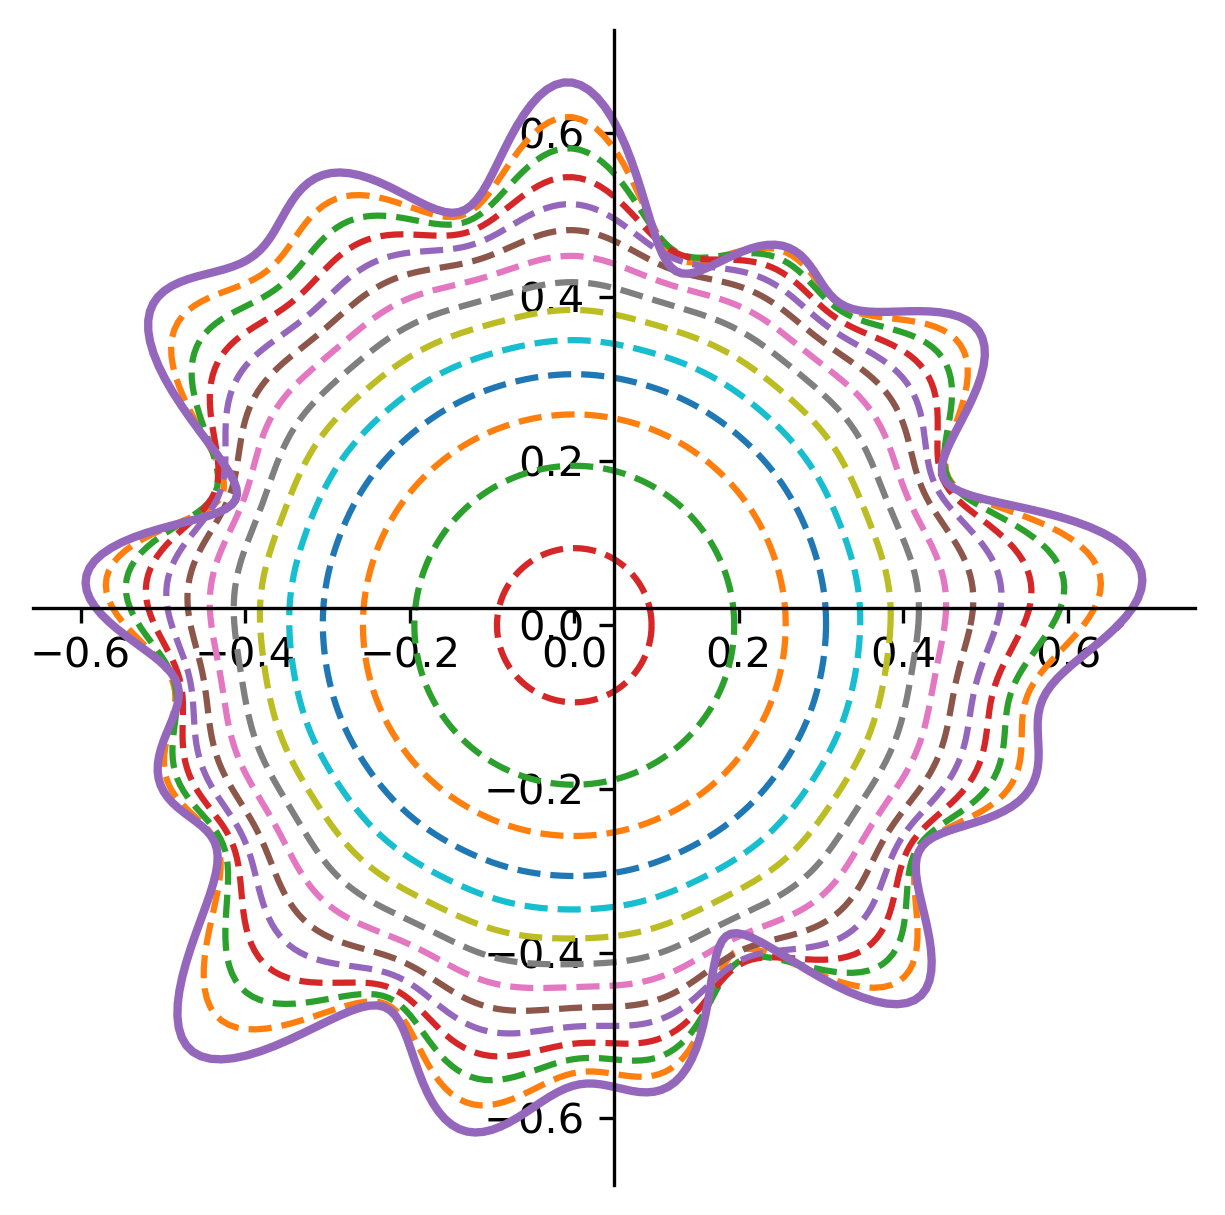

In [28]:
fig = plt.figure(figsize=(5,5), dpi=300)
ax=fig.add_subplot(1,1,1)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for i in np.arange(0,Dimensions,30):
    ax.plot(x[i], y[i],linestyle='--')
ax.plot(x[0], y[0], lw=2)

# fig.savefig('flower_contour.pdf', bbox_inches='tight')

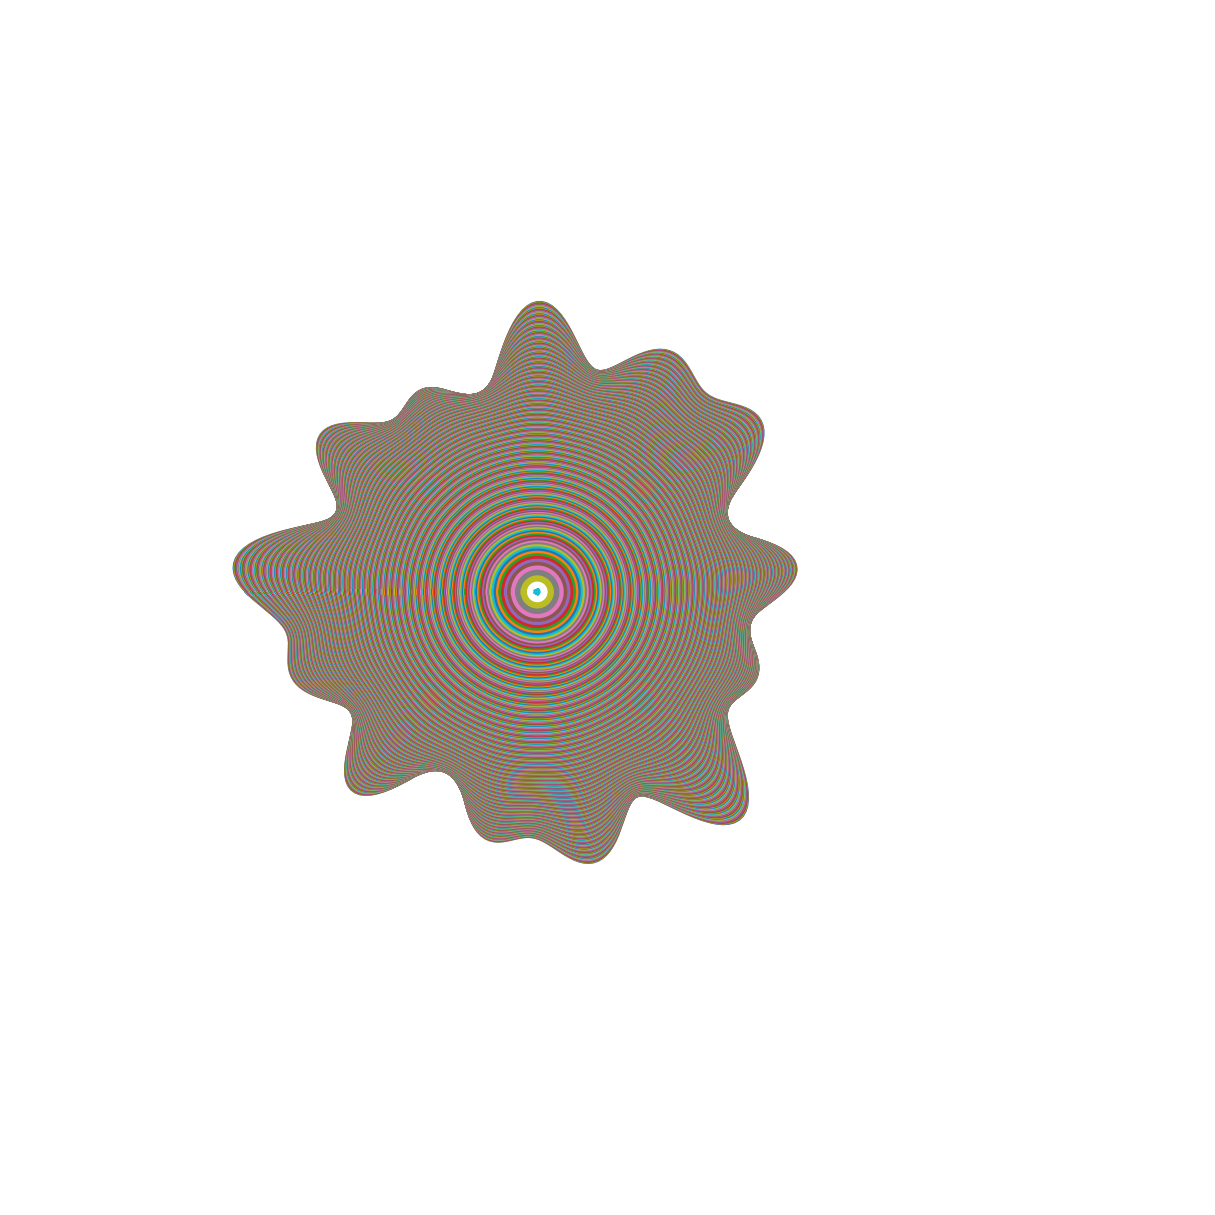

In [29]:
fig = plt.figure(figsize = (5,5), dpi=300)
#fig = plt.figure(figsize=plt.figaspect(1)*2)
ax = plt.axes(projection='3d')
#ax.view_init(elev=-90, azim=0, roll=0)
#ax.view_init(elev=-3, azim=0)
ax.view_init(elev=-90, azim=90)
#ax.view_init(elev=20, azim=90)
plt.axis("equal")
ax.set_box_aspect([1,1,1])
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))



for i in np.arange(0,Dimensions,1):
        ax.plot(x[i], y[i], z_0*z[i])
#ax.plot(x[190],y[190],z_0*z[190])
#ax.plot(x[5],y[5],z_0*z[5])
ax.set_zlim(0, 1.6)
ax.set_xlim(-1, 0.6)
ax.set_ylim(-0.8, 0.8)


ax.set_axis_off()
ax.grid(False)
#fig.savefig('contour_3Dhex01.pdf', bbox_inches='tight')

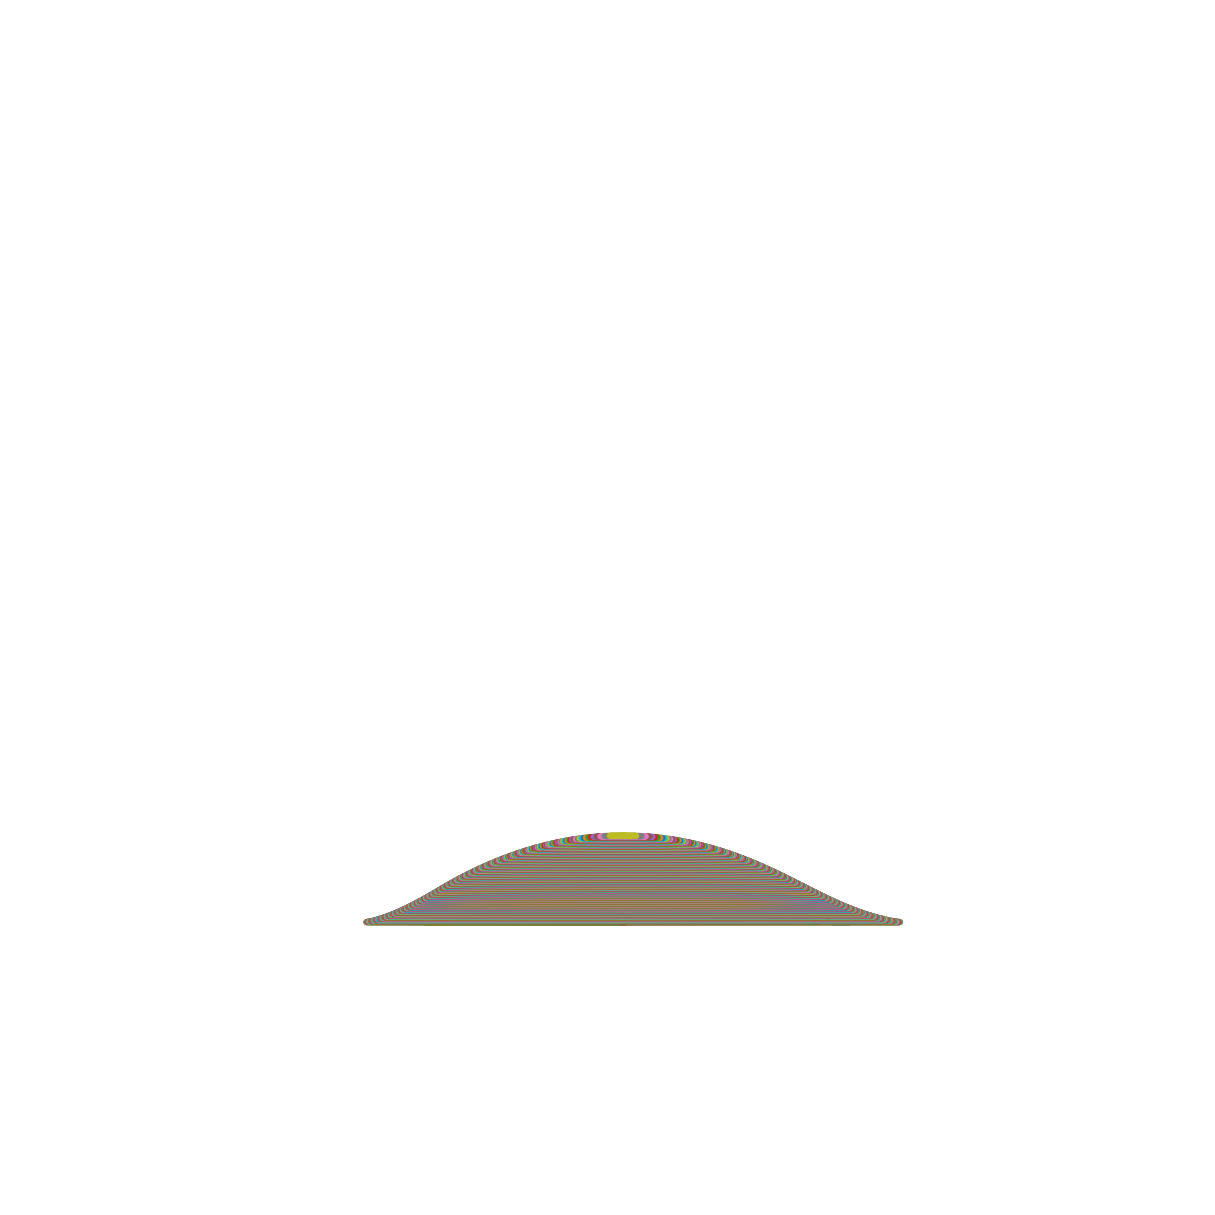

In [30]:
fig = plt.figure(figsize = (5,5), dpi=300)
#fig = plt.figure(figsize=plt.figaspect(1)*2)
ax = plt.axes(projection='3d')
#ax.view_init(elev=-90, azim=0, roll=0)
ax.view_init(elev=-3, azim=0)
#ax.view_init(elev=-90, azim=90)
#ax.view_init(elev=20, azim=90)
plt.axis("equal")
ax.set_box_aspect([1,1,1])
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))



for i in np.arange(0,Dimensions,1):
        ax.plot(x[i], y[i], z_0*z[i])
#ax.plot(x[190],y[190],z_0*z[190])
#ax.plot(x[5],y[5],z_0*z[5])
ax.set_zlim(0, 1.6)
ax.set_xlim(-1, 0.6)
ax.set_ylim(-0.8, 0.8)


ax.set_axis_off()
ax.grid(False)
fig.savefig('contour_3Dhex01.pdf', bbox_inches='tight')

In [31]:
V=0.5 h=[0.6902226684306767]

##############THEO#################

Surface#####

[2.552913267335488]

m_matrix

[array([-0.78])]

n_matrix

[array([1.35])]

SyntaxError: invalid syntax (1676318278.py, line 1)